<a href="https://colab.research.google.com/github/Aditya-Shandilya1182/extreme_classification/blob/main/Test_For_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
import numpy as np


In [14]:
import math

In [15]:
class ParameterizedGeLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='GlorotNormal', beta_initializer='GlorotNormal', **kwargs):
        super(ParameterizedGeLU, self).__init__(**kwargs)
        self.alpha_initializer = initializers.get(alpha_initializer)
        self.beta_initializer = initializers.get(beta_initializer)
        self.alpha_values = []
        self.beta_values = []

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(1,), initializer=self.alpha_initializer, name='alpha')
        self.beta = self.add_weight(shape=(1,), initializer=self.beta_initializer, name='beta')
        super(ParameterizedGeLU, self).build(input_shape)

    def call(self, inputs, training = None):
        alpha = self.alpha
        beta = self.beta
        const = math.sqrt(2 / math.pi)
        if training:
            self.alpha_values.append(alpha)
            self.beta_values.append(beta)
        return self.beta * 0.5 * inputs * (1 + tf.tanh(const * (self.alpha * inputs + 0.044715 * tf.pow(inputs, 3))))

    def get_config(self):
        config = super(ParameterizedGeLU, self).get_config()
        config.update({
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'beta_initializer': initializers.serialize(self.beta_initializer)
        })
        return config

In [16]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):

   def __init__(self, num_heads, d_model, dropout_rate=0.1):
      super(MultiHeadSelfAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert self.d_model % self.num_heads == 0
      self.depth = self.d_model // self.num_heads
      self.query_dense = Dense(self.d_model)
      self.key_dense = Dense(self.d_model)
      self.value_dense = Dense(self.d_model)
      self.dropout = Dropout(dropout_rate)
      self.final_dense = Dense(self.d_model)

   def split_heads(self, inputs, batch_size):
      inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(inputs, perm=[0, 2, 1, 3])

   def call(self, inputs):
      batch_size = tf.shape(inputs)[0]
      query = self.query_dense(inputs)
      key = self.key_dense(inputs)
      value = self.value_dense(inputs)
      query = self.split_heads(query, batch_size)
      key = self.split_heads(key, batch_size)
      value = self.split_heads(value, batch_size)
      scaled_attention, attention_weights = self.scaled_dot_product_attention(query, key, value)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
      concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
      outputs = self.final_dense(concat_attention)
      return outputs

   def scaled_dot_product_attention(self, query, key, value):
      matmul_qk = tf.matmul(query, key, transpose_b=True)
      dk = tf.cast(tf.shape(key)[-1], tf.float32)
      scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
      attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
      output = tf.matmul(attention_weights, value)
      return output, attention_weights

In [17]:
class TextClassificationModel:

  def __init__(self, vocab_size, embedding_dim, max_length, num_classes):
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.max_length = max_length
    self.num_classes = num_classes

  def build_model(self):
    inputs = Input(shape=(self.max_length,))
    embedding_layer = Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length)(inputs)
    attention_output = MultiHeadSelfAttention(num_heads=8, d_model=self.embedding_dim)(embedding_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + embedding_layer)
    ffnn_output = Dense(128)(attention_output)
    gelu_layer = ParameterizedGeLU()(ffnn_output)  # Using Parameterized GeLU activation
    ffnn_output = Dense(64)(gelu_layer)
    gelu_layer = ParameterizedGeLU()(ffnn_output)  # Using Parameterized GeLU activation
    ffnn_output = Dense(32)(gelu_layer)
    gelu_layer = ParameterizedGeLU()(ffnn_output)  # Using Parameterized GeLU activation
    global_pooling = GlobalAveragePooling1D()(gelu_layer)
    outputs = Dense(1, activation='sigmoid')(global_pooling)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [18]:
import matplotlib.pyplot as plt

def plot_alpha_beta_values(model):
    # Access alpha and beta values
    alpha_values = model.layers[-5].alpha_values
    beta_values = model.layers[-5].beta_values

    # Plot alpha and beta values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(alpha_values)
    plt.title('Alpha Values')
    plt.xlabel('Training Iterations')
    plt.ylabel('Alpha')

    plt.subplot(1, 2, 2)
    plt.plot(beta_values)
    plt.title('Beta Values')
    plt.xlabel('Training Iterations')
    plt.ylabel('Beta')

    plt.tight_layout()
    plt.show()


In [19]:
class SaveAlphaBetaValues(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.alpha_beta_values = []

    def on_epoch_end(self, epoch, logs=None):
        epoch_values = {'epoch': epoch + 1, 'layers': []}
        print(f"Epoch {epoch + 1}:")
        for i, layer in enumerate(self.model.layers):
            if isinstance(layer, ParameterizedGeLU):
                alpha_values = layer.alpha_values[-1]
                beta_values = layer.beta_values[-1]
                print(f"Layer {i + 1}: Alpha = {alpha_values}, Beta = {beta_values}")
                epoch_values['layers'].append({'layer': i + 1, 'alpha': alpha_values, 'beta': beta_values})
        self.alpha_beta_values.append(epoch_values)

    def get_alpha_beta_values(self):
        return self.alpha_beta_values


In [20]:
# Example usage:
vocab_size = 10000
embedding_dim = 128
max_length = 256
num_classes = 2  # binary classification task

text_classifier = TextClassificationModel(vocab_size, embedding_dim, max_length, num_classes)
model = text_classifier.build_model()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 256, 128)             1280000   ['input_2[0][0]']             
                                                                                                  
 multi_head_self_attention_  (None, None, 128)            66048     ['embedding_1[0][0]']         
 1 (MultiHeadSelfAttention)                                                                       
                                                                                                  
 tf.__operators__.add_1 (TF  (None, 256, 128)             0         ['multi_head_self_attent

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_length)
x_test = pad_sequences(x_test, maxlen=max_length)


In [23]:
x_train.shape

(25000, 256)

In [24]:
callback = SaveAlphaBetaValues(model)

history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test), callbacks=[callback])


# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7218Epoch 1:
Layer 7: Alpha = <tf.Variable 'parameterized_ge_lu_3/alpha:0' shape=(1,) dtype=float32, numpy=array([1.942222], dtype=float32)>, Beta = <tf.Variable 'parameterized_ge_lu_3/beta:0' shape=(1,) dtype=float32, numpy=array([0.7571394], dtype=float32)>
Layer 9: Alpha = <tf.Variable 'parameterized_ge_lu_4/alpha:0' shape=(1,) dtype=float32, numpy=array([1.5823486], dtype=float32)>, Beta = <tf.Variable 'parameterized_ge_lu_4/beta:0' shape=(1,) dtype=float32, numpy=array([-1.712548], dtype=float32)>
Layer 11: Alpha = <tf.Variable 'parameterized_ge_lu_5/alpha:0' shape=(1,) dtype=float32, numpy=array([-1.6600717], dtype=float32)>, Beta = <tf.Variable 'parameterized_ge_lu_5/beta:0' shape=(1,) dtype=float32, numpy=array([-1.9608916], dtype=float32)>
49/49 [==============================] - 23s 301ms/step - loss: 0.5393 - accuracy: 0.7218 - val_loss: 0.3219 - val_accuracy: 0.8635
Epoch 2/20
49/49 [==

In [25]:
alpha_beta_values = callback.get_alpha_beta_values()

In [32]:
alpha_beta_values

[{'epoch': 1,
  'layers': [{'layer': 7,
    'alpha': <tf.Variable 'parameterized_ge_lu_3/alpha:0' shape=(1,) dtype=float32, numpy=array([1.9481512], dtype=float32)>,
    'beta': <tf.Variable 'parameterized_ge_lu_3/beta:0' shape=(1,) dtype=float32, numpy=array([0.8181126], dtype=float32)>},
   {'layer': 9,
    'alpha': <tf.Variable 'parameterized_ge_lu_4/alpha:0' shape=(1,) dtype=float32, numpy=array([1.5900246], dtype=float32)>,
    'beta': <tf.Variable 'parameterized_ge_lu_4/beta:0' shape=(1,) dtype=float32, numpy=array([-1.7718207], dtype=float32)>},
   {'layer': 11,
    'alpha': <tf.Variable 'parameterized_ge_lu_5/alpha:0' shape=(1,) dtype=float32, numpy=array([-1.6904784], dtype=float32)>,
    'beta': <tf.Variable 'parameterized_ge_lu_5/beta:0' shape=(1,) dtype=float32, numpy=array([-2.0300858], dtype=float32)>}]},
 {'epoch': 2,
  'layers': [{'layer': 7,
    'alpha': <tf.Variable 'parameterized_ge_lu_3/alpha:0' shape=(1,) dtype=float32, numpy=array([1.9481512], dtype=float32)>,
   

In [34]:
alpha_beta_array = []

for epoch_data in alpha_beta_values:
    epoch_array = []
    for layer_data in epoch_data['layers']:
        alpha_value = layer_data['alpha'][0]  # Extract the first element of the list
        beta_value = layer_data['beta'][0]    # Extract the first element of the list
        epoch_array.append([alpha_value, beta_value])
    alpha_beta_array.append(epoch_array)

alpha_beta_array = np.array(alpha_beta_array)

In [46]:
alpha_beta_array

array([[[-5.85680624e-01, -1.02560232e+00],
        [ 1.86901123e+00, -2.89863577e-01],
        [-1.98418619e+00, -7.46426009e-01]],

       [[ 1.05719136e+00, -1.33510842e+00],
        [-2.13084409e+00,  1.40824622e-01],
        [ 4.19053685e-01,  9.86807231e-01]],

       [[-2.93251201e-01,  1.01646076e+00],
        [ 1.18549960e+00, -9.87301204e-01],
        [-5.88171937e-01, -3.85270522e-01]],

       [[-1.28379266e+00,  9.48328716e-01],
        [ 1.07440124e+00,  6.20128464e-01],
        [-1.61793158e+00, -1.95124559e-01]],

       [[ 4.10741822e-01, -3.32810189e-01],
        [ 6.12515424e-01, -1.12453559e-01],
        [-1.99884930e-01,  1.01121542e+00]],

       [[-7.18456992e-01,  6.37788772e-01],
        [ 1.14652417e+00,  1.59364663e+00],
        [-9.21638799e-01, -1.02194903e+00]],

       [[-2.16896417e-01,  7.51144994e-01],
        [-8.57870183e-01,  3.46928067e-01],
        [-1.96750606e-01,  2.40789057e+00]],

       [[ 7.07748788e-01,  3.28543154e-01],
        [-7.496429

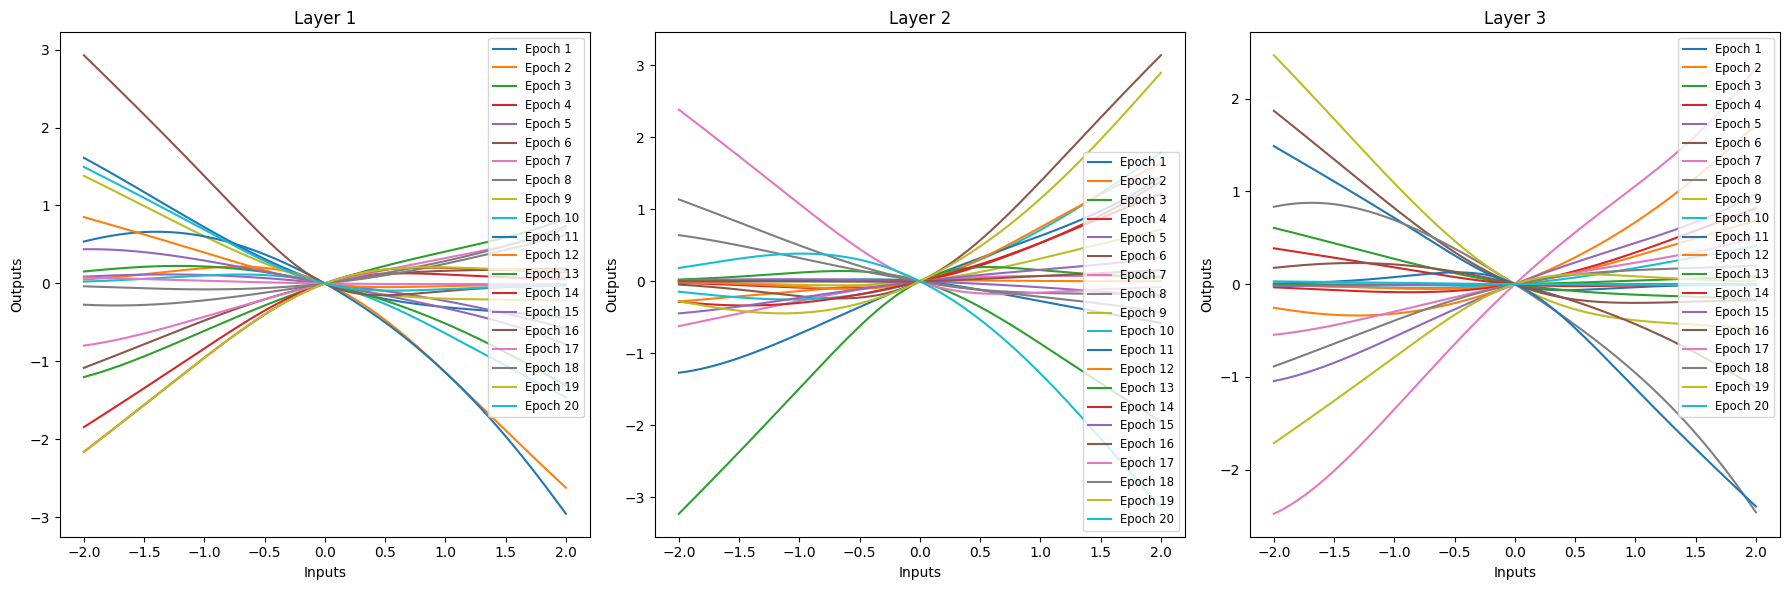

In [40]:
def parameterized_gelu(alpha, beta, inputs):
    const = math.sqrt(2 / math.pi)
    return beta * 0.5 * inputs * (1 + tf.tanh(const * (alpha * inputs + 0.044715 * tf.pow(inputs, 3))))

# Generate input values for plotting
inputs = np.linspace(-2, 2, 400)  # 400 points between -5 and 5

# Plotting the results
plt.figure(figsize=(18, 6))

for layer_idx in range(3):
    plt.subplot(1, 3, layer_idx + 1)

    for epoch_idx in range(20):
        alpha = alpha_beta_array[epoch_idx, layer_idx, 0]
        beta = alpha_beta_array[epoch_idx, layer_idx, 1]
        outputs = parameterized_gelu(alpha, beta, inputs)
        plt.plot(inputs, outputs, label=f'Epoch {epoch_idx + 1}')

    plt.title(f'Layer {layer_idx + 1}')
    plt.xlabel('Inputs')
    plt.ylabel('Outputs')
    plt.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()

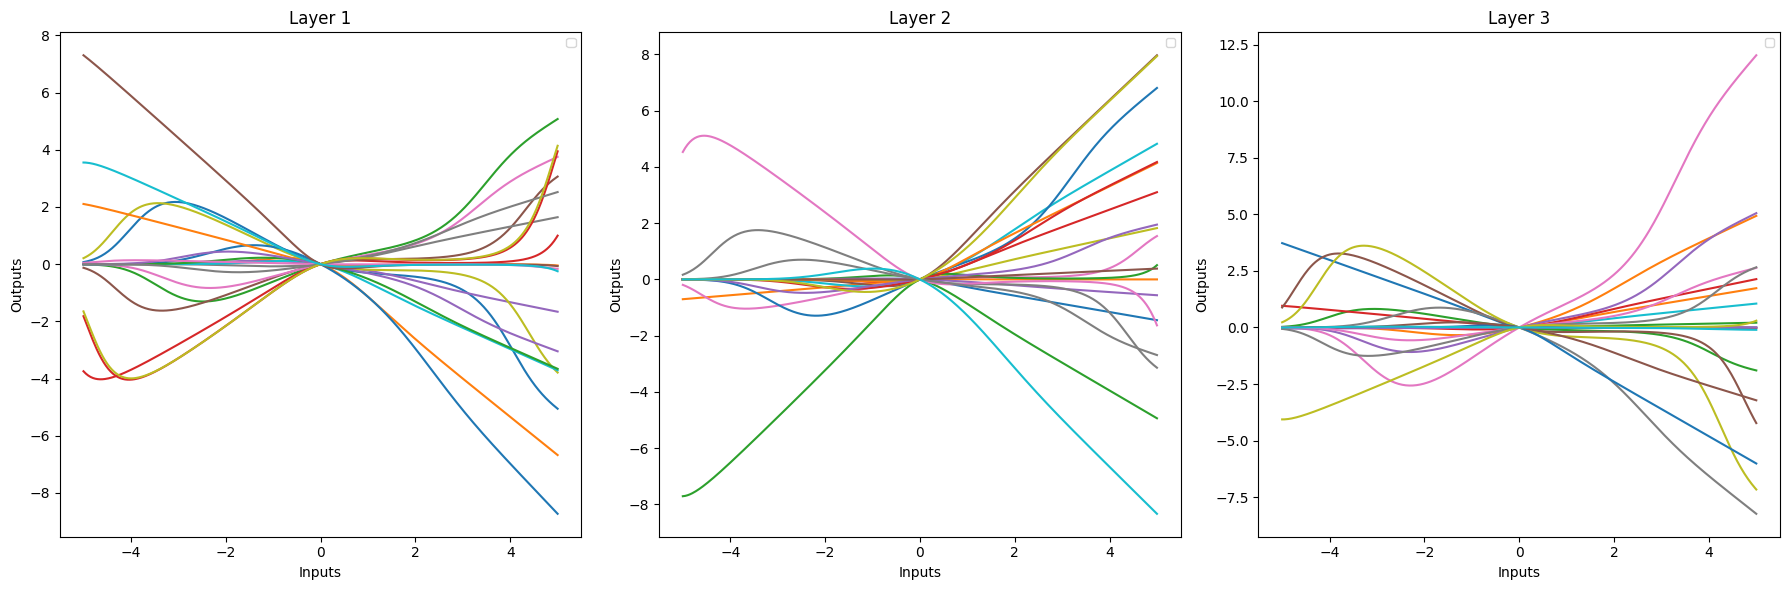

In [39]:
alpha_beta_array = np.random.randn(20, 3, 2)  # Replace with actual alpha_beta_array from training

# Function to compute the parameterized GeLU output
def parameterized_gelu(alpha, beta, inputs):
    const = math.sqrt(2 / math.pi)
    return beta * 0.5 * inputs * (1 + tf.tanh(const * (alpha * inputs + 0.044715 * tf.pow(inputs, 3))))

# Generate input values for plotting
inputs = np.linspace(-5, 5, 400)  # 400 points between -5 and 5

# Plotting the results
plt.figure(figsize=(18, 6))

for layer_idx in range(3):
    plt.subplot(1, 3, layer_idx + 1)

    for epoch_idx in range(20):
        alpha = alpha_beta_array[epoch_idx, layer_idx, 0]
        beta = alpha_beta_array[epoch_idx, layer_idx, 1]
        outputs = parameterized_gelu(alpha, beta, inputs)
        plt.plot(inputs, outputs)

    plt.title(f'Layer {layer_idx + 1}')
    plt.xlabel('Inputs')
    plt.ylabel('Outputs')
    plt.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()

<ipython-input-60-b916b2140160>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=alpha_beta_array[i, :, j], ax=axes[i, j], jitter=0.2, palette='viridis', alpha=0.6)
<ipython-input-60-b916b2140160>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=alpha_beta_array[i, :, j], ax=axes[i, j], jitter=0.2, palette='viridis', alpha=0.6)
<ipython-input-60-b916b2140160>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=alpha_beta_array[i, :, j], ax=axes[i, j], jitter=0.2, palette='viridis', alpha=0.6)
<ipython-input-60-b916b2140160>:6: Futur

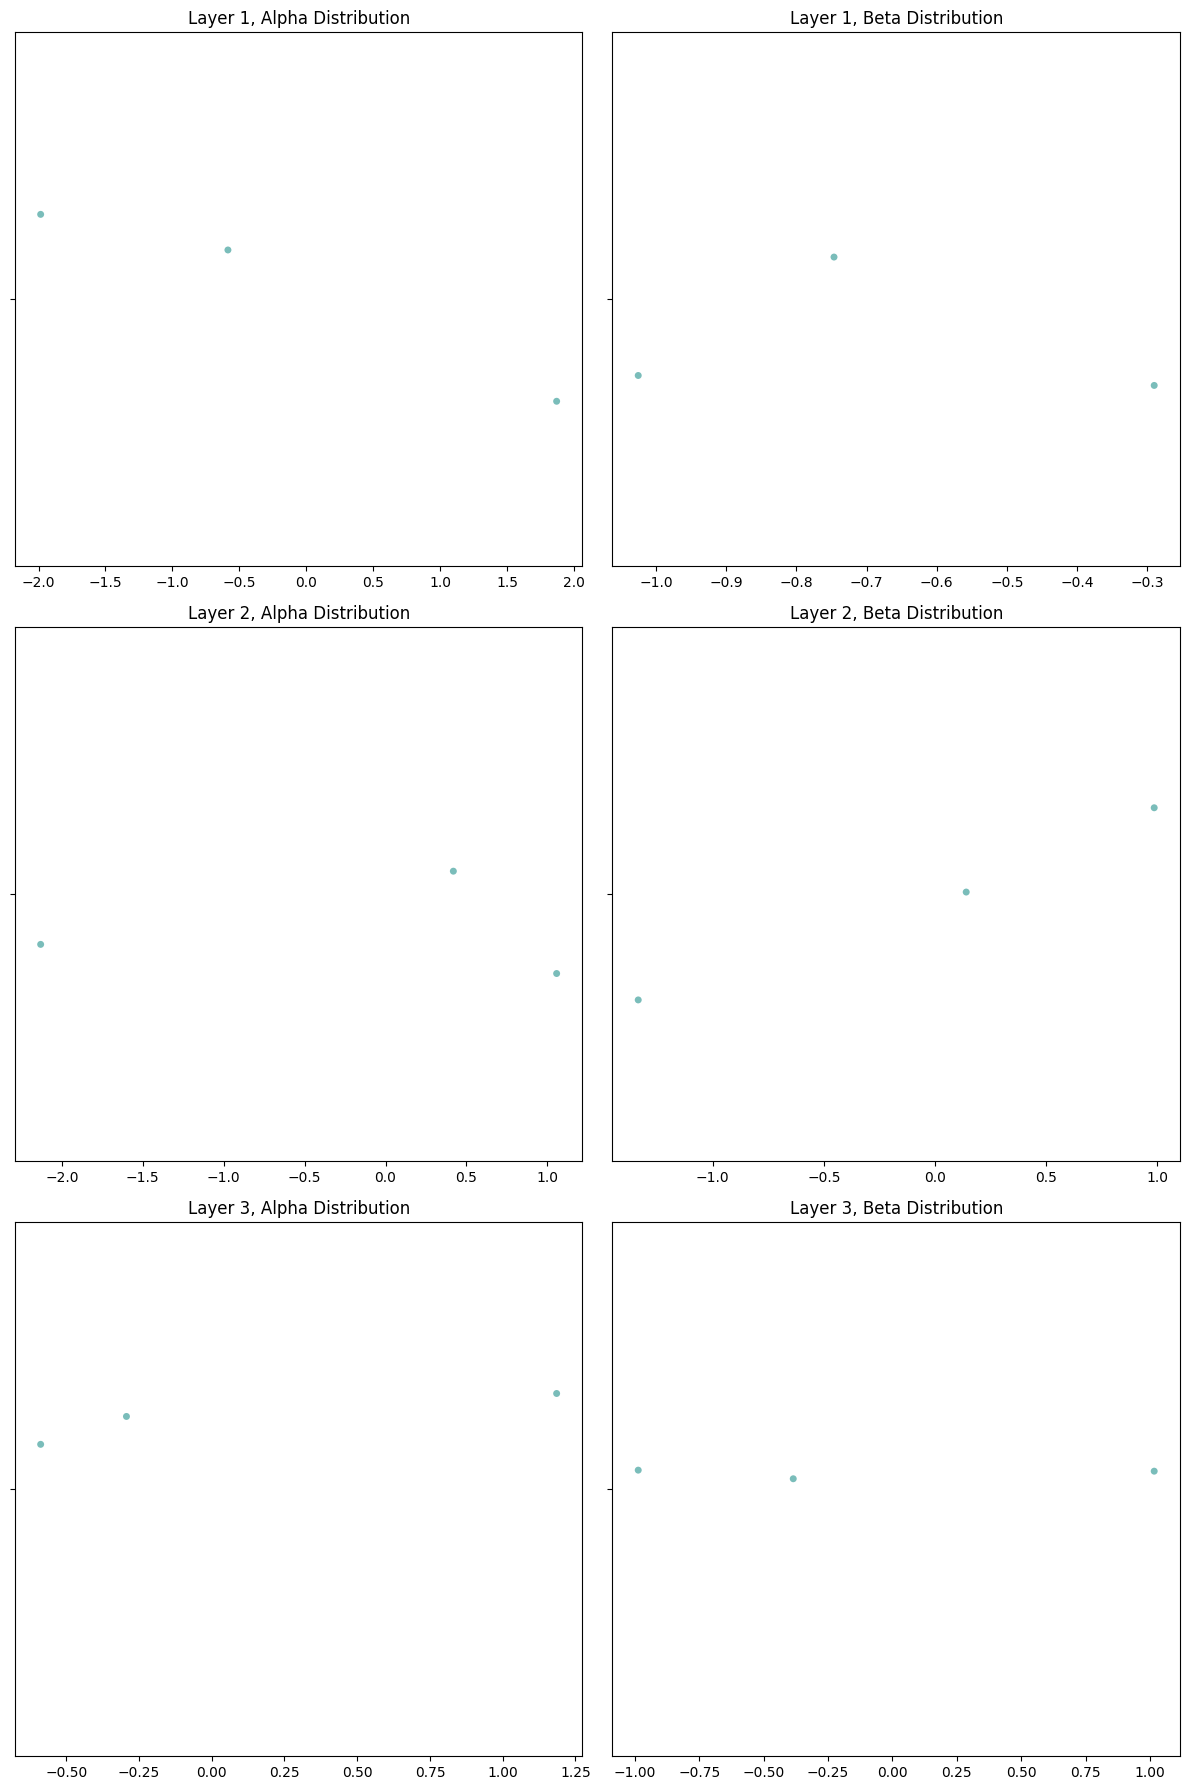

In [60]:
import seaborn as sns
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

for i in range(3):
    for j in range(2):
        sns.stripplot(x=alpha_beta_array[i, :, j], ax=axes[i, j], jitter=0.2, palette='viridis', alpha=0.6)
        axes[i, j].set_title(f'Layer {i+1}, {"Alpha" if j==0 else "Beta"} Distribution')

plt.tight_layout()
plt.show()